# Project 

## Bitcoin Predictor

### Now we'll grab the bitcoin market data and price history!

In [1]:
import requests
import pandas as pd
from fbprophet import Prophet
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
bitcoin = 'https://api.coingecko.com/api/v3/coins/bitcoin/market_chart?vs_currency=USD&days=365'

In [3]:
bit_coin = requests.get(bitcoin)
bit_json = bit_coin.json()
type(bit_json)

dict

In [4]:
bitcoin_prices = bit_json['prices']

In [5]:
bitcoin_df = pd.DataFrame(bitcoin_prices, columns=['DateTime', 'Prices'])
bitcoin_df.head()

,DateTime,Prices
0,1525392000000,9551.135184
1,1525478400000,9634.538226
2,1525564800000,9766.244485
3,1525651200000,9583.871746
4,1525737600000,9308.265026


In [6]:
bitcoin_df.shape

(366, 2)

First column is probably a raw data time column! and the other is price

In [7]:
bitcoin_df['DateTime'] = pd.to_datetime(bitcoin_df['DateTime'], unit='ms') 
bitcoin_df.tail()

,DateTime,Prices
361,2019-04-30 00:00:00,5199.755009
362,2019-05-01 00:00:00,5292.803975
363,2019-05-02 00:00:00,5354.586800
364,2019-05-03 00:00:00,5450.706620
365,2019-05-03 03:58:52,5530.453499


In [8]:
bitcoin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
DateTime    366 non-null datetime64[ns]
Prices      366 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.8 KB


Calculate a rolling mean value by taking the prices column, the last 28 values(days), and calculating the average for those 28 values, finally filling the first 28 (blank) values with the value from the first mean value

In [9]:
bitcoin_df['rolling_mean_price'] = bitcoin_df['Prices'].rolling(28).mean().fillna(method='bfill')

In [10]:
bitcoin_df.head()

,DateTime,Prices,rolling_mean_price
0,2018-05-04,9551.135184,8383.341108
1,2018-05-05,9634.538226,8383.341108
2,2018-05-06,9766.244485,8383.341108
3,2018-05-07,9583.871746,8383.341108
4,2018-05-08,9308.265026,8383.341108


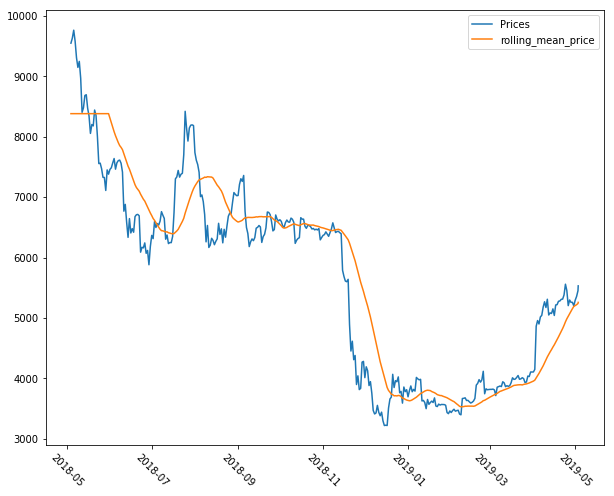

In [11]:
plt.figure(figsize=(10,8))
plt.plot(bitcoin_df['DateTime'], bitcoin_df['Prices'])
plt.plot(bitcoin_df['DateTime'], bitcoin_df['rolling_mean_price'])

plt.xticks(rotation=-45)
plt.legend()

## Let's upscale

## Compare to train data

## Predict future values

## Play around with how many days 

In [12]:
bitcoin_df = bitcoin_df.set_index('DateTime').drop(columns='rolling_mean_price')

In [13]:
bitcoin_df.head()

,Prices
DateTime,
2018-05-04,9551.135184
2018-05-05,9634.538226
2018-05-06,9766.244485
2018-05-07,9583.871746
2018-05-08,9308.265026


In [14]:
upsample_series = bitcoin_df['Prices'].resample('H')

In [15]:
linear_upsample = upsample_series.interpolate()
cubic_upsample = upsample_series.interpolate(method='cubic')
quadratic_upsample = upsample_series.interpolate(method='quadratic')

linear_upsample.head(3)

DateTime
2018-05-04 00:00:00    9551.135184
2018-05-04 01:00:00    9554.610311
2018-05-04 02:00:00    9558.085437
Freq: H, Name: Prices, dtype: float64

In [16]:
cubic_upsample.head(3)

DateTime
2018-05-04 00:00:00    9551.135184
2018-05-04 01:00:00    9546.834019
2018-05-04 02:00:00    9543.486319
Freq: H, Name: Prices, dtype: float64

In [17]:
quadratic_upsample.head(3)

DateTime
2018-05-04 00:00:00    9551.135184
2018-05-04 01:00:00    9552.291678
2018-05-04 02:00:00    9553.649792
Freq: H, Name: Prices, dtype: float64

In [18]:
linear_upsample.shape

(8740,)

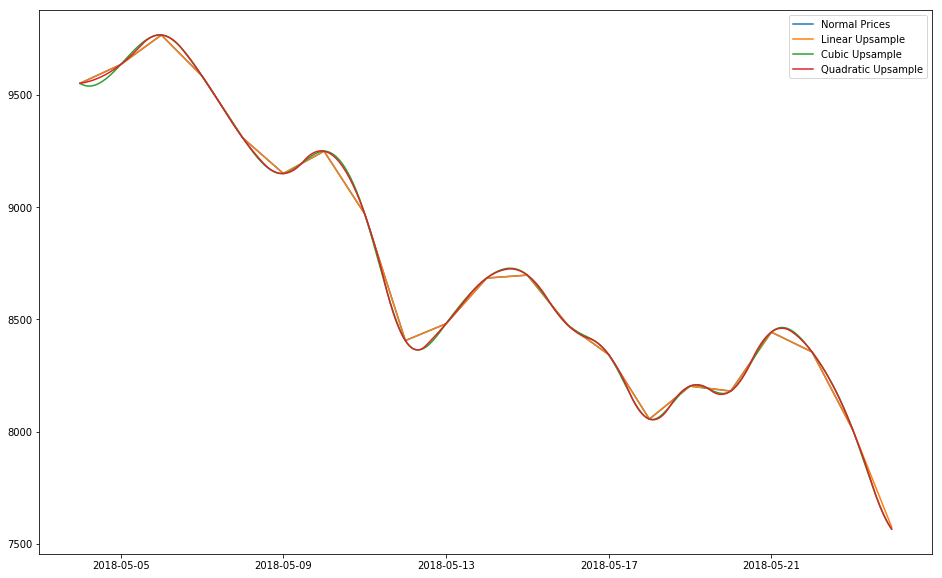

In [19]:
plt.figure(figsize=(16,10))

plt.plot(bitcoin_df.index[:20], bitcoin_df['Prices'][:20])
plt.plot(linear_upsample.index[:480], linear_upsample[:480])
plt.plot(cubic_upsample.index[:480], cubic_upsample[:480])
plt.plot(quadratic_upsample.index[:480], quadratic_upsample[:480])

plt.legend(['Normal Prices', 'Linear Upsample', 'Cubic Upsample', 'Quadratic Upsample'])
plt.show()

## Separate some of the final rows of our hourly predictions for test data

In [20]:
linear_df = linear_upsample.to_frame()
cubic_df = cubic_upsample.to_frame()
quadratic_df = quadratic_upsample.to_frame()

In [21]:
linear_prophet = linear_df.reset_index().rename(columns={'DateTime': 'ds', 'Prices': 'y'}).iloc[:8689]
cubic_prophet = cubic_df.reset_index().rename(columns={'DateTime': 'ds', 'Prices': 'y'}).iloc[:8689]
quadratic_prophet = quadratic_df.reset_index().rename(columns={'DateTime': 'ds', 'Prices': 'y'}).iloc[:8689]

#### I have here deleted the final 51 hourly values for my bitcoin data - I can now use Prophet to detect which of the models is best: linear, cubic, or quadratic!

## Now, let's use Prophet on our Test Data!

#### First, for linear model:

In [22]:
mlin = Prophet()

In [23]:
mlin.fit(linear_prophet)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
/Users/maximcondon/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [24]:
linear_test = mlin.make_future_dataframe(periods=51, freq = 'H', include_history=False)

In [25]:
forecast_linear_test = mlin.predict(linear_test)

In [27]:
forecast_linear_test[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2019-05-01 01:00:00,5407.125483,5093.058372,5673.433752
1,2019-05-01 02:00:00,5408.716248,5142.292641,5703.532735
2,2019-05-01 03:00:00,5410.247998,5116.169087,5706.021051
3,2019-05-01 04:00:00,5411.670654,5109.161252,5700.653898
4,2019-05-01 05:00:00,5412.964797,5126.709784,5706.496894


In [32]:
forecast_linear_test[['ds','yhat']].head()

,ds,yhat
0,2019-05-01 01:00:00,5407.125483
1,2019-05-01 02:00:00,5408.716248
2,2019-05-01 03:00:00,5410.247998
3,2019-05-01 04:00:00,5411.670654
4,2019-05-01 05:00:00,5412.964797


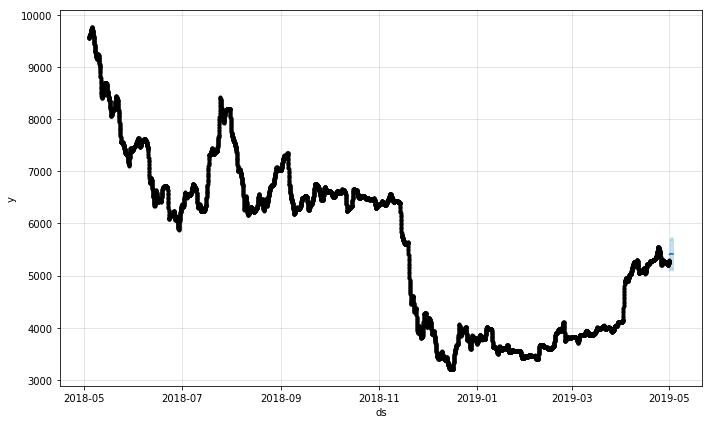

In [29]:
fig_lin = mlin.plot(forecast_linear_test) # The blue part is the actual forecast
None

#### Second, the cubic model:

In [30]:
mcub = Prophet()

mcub.fit(cubic_prophet)

cubic_test = mcub.make_future_dataframe(periods=51, freq = 'H', include_history=False)

forecast_cubic_test = mcub.predict(cubic_test)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [31]:
forecast_cubic_test[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2019-05-01 01:00:00,5410.048027,5092.460690,5701.265945
1,2019-05-01 02:00:00,5411.778469,5099.148170,5705.418573
2,2019-05-01 03:00:00,5413.426615,5073.867763,5706.158575
3,2019-05-01 04:00:00,5414.945582,5111.818888,5719.452360
4,2019-05-01 05:00:00,5416.317745,5124.713021,5716.288062


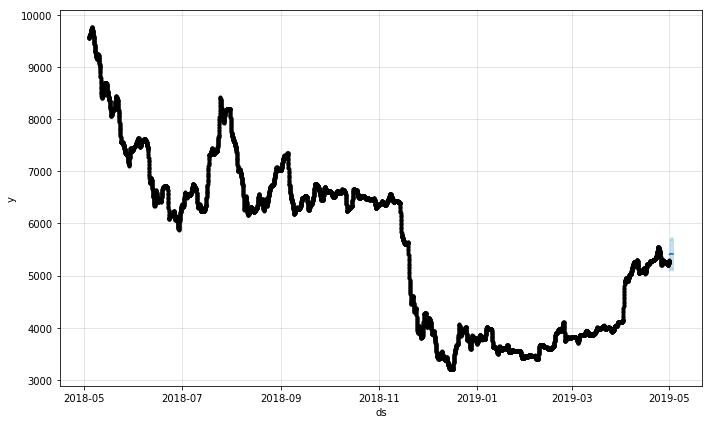

In [33]:
fig_cub = mlin.plot(forecast_linear_test) # The blue part is the actual forecast
None

#### Finally, for the quadratic model:

In [34]:
mquad = Prophet()

mquad.fit(quadratic_prophet)

quadratic_test = mquad.make_future_dataframe(periods=51, freq = 'H', include_history=False)

forecast_quadratic_test = mquad.predict(quadratic_test)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [35]:
forecast_quadratic_test[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2019-05-01 01:00:00,5408.401084,5110.023030,5694.810775
1,2019-05-01 02:00:00,5410.115112,5105.016914,5692.841867
2,2019-05-01 03:00:00,5411.747275,5111.578103,5710.568826
3,2019-05-01 04:00:00,5413.248634,5126.512804,5732.416811
4,2019-05-01 05:00:00,5414.602106,5121.358465,5733.187207


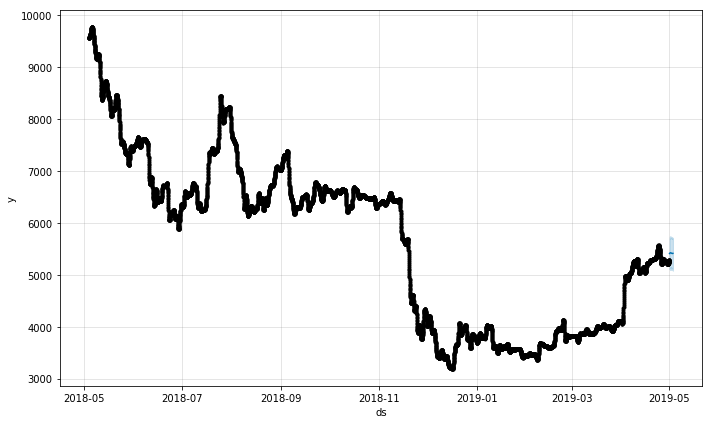

In [36]:
fig_quad = mquad.plot(forecast_quadratic_test) # The blue part is the actual forecast
None

## Now we can compare this to our actual data in the original bitcoin dataframe!

### We can see which is the best predictor


#### Now let's plot it with ALL the data and find out what the predictions will be for the next 2 days!

In [37]:
bitcoin_df.tail(3)

,Prices
DateTime,
2019-05-02 00:00:00,5354.586800
2019-05-03 00:00:00,5450.706620
2019-05-03 03:58:52,5530.453499


In [38]:
print(forecast_linear_test[['ds', 'yhat']].iloc[23])
print(forecast_linear_test[['ds', 'yhat']].iloc[47])

ds      2019-05-02 00:00:00
yhat                5419.65
Name: 23, dtype: object
ds      2019-05-03 00:00:00
yhat                5414.68
Name: 47, dtype: object


In [39]:
print(forecast_cubic_test[['ds', 'yhat']].iloc[23])
print(forecast_cubic_test[['ds', 'yhat']].iloc[47])

ds      2019-05-02 00:00:00
yhat                5420.52
Name: 23, dtype: object
ds      2019-05-03 00:00:00
yhat                5411.02
Name: 47, dtype: object


In [41]:
print(forecast_quadratic_test[['ds', 'yhat']].iloc[23])
print(forecast_quadratic_test[['ds', 'yhat']].iloc[47])

ds      2019-05-02 00:00:00
yhat                5418.79
Name: 23, dtype: object
ds      2019-05-03 00:00:00
yhat                5409.87
Name: 47, dtype: object


### It seems like just about the linear prediction for prophet is marginally better than the rest so let's run our prediction on that!

In [67]:
linear_model = linear_df.reset_index().rename(columns={'DateTime': 'ds', 'Prices': 'y'})

In [76]:
m = Prophet()

m.fit(linear_model)

linear_future = m.make_future_dataframe(periods=70, freq = 'H', include_history=False)

forecast_linear = m.predict(linear_future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [84]:
forecast_linear[['ds','yhat', 'yhat_lower', 'yhat_upper']].tail(20)

,ds,yhat,yhat_lower,yhat_upper
50,2019-05-05 06:00:00,5495.761233,5219.427579,5771.791322
51,2019-05-05 07:00:00,5497.396298,5206.090285,5768.271935
52,2019-05-05 08:00:00,5499.026937,5208.620030,5789.155800
53,2019-05-05 09:00:00,5500.638631,5224.171313,5796.841023
54,2019-05-05 10:00:00,5502.205732,5225.862405,5791.905264
55,2019-05-05 11:00:00,5503.721511,5216.874153,5803.341215
56,2019-05-05 12:00:00,5505.207416,5211.216160,5814.223527
57,2019-05-05 13:00:00,5506.690620,5226.238571,5800.643346
58,2019-05-05 14:00:00,5508.173434,5215.595385,5808.602151
59,2019-05-05 15:00:00,5509.627784,5198.410846,5806.716197


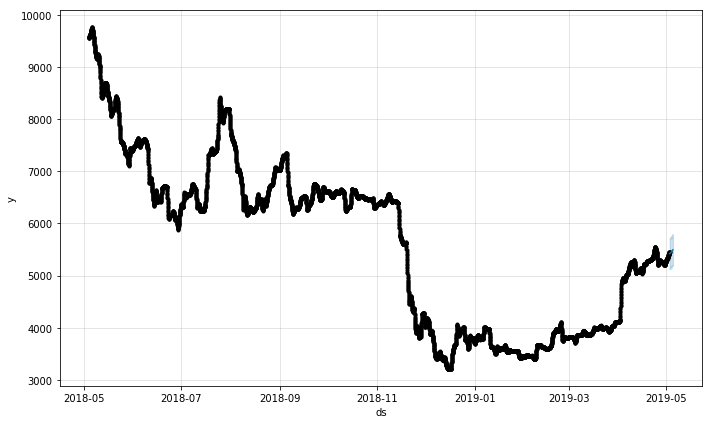

In [74]:
fig_linear_future = m.plot(forecast_linear) # The blue part is the actual forecast
None

### Cubic prediction

In [78]:
cubic_model = cubic_df.reset_index().rename(columns={'DateTime': 'ds', 'Prices': 'y'})

In [79]:
m = Prophet()

m.fit(cubic_model)

cubic_future = m.make_future_dataframe(periods=70, freq = 'H', include_history=False)

forecast_cubic = m.predict(cubic_future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
/Users/maximcondon/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [91]:
forecast_cubic[['ds','yhat', 'yhat_lower', 'yhat_upper']].iloc[38]

ds            2019-05-04 18:00:00
yhat                      5475.88
yhat_lower                5173.41
yhat_upper                 5759.4
Name: 38, dtype: object

In [92]:
forecast_cubic[['ds','yhat', 'yhat_lower', 'yhat_upper']].iloc[62]

ds            2019-05-05 18:00:00
yhat                      5515.55
yhat_lower                 5214.6
yhat_upper                5838.84
Name: 62, dtype: object

### Quadratic Model

In [85]:
quadratic_model = quadratic_df.reset_index().rename(columns={'DateTime': 'ds', 'Prices': 'y'})

In [87]:
m = Prophet()

m.fit(quadratic_model)

quadratic_future = m.make_future_dataframe(periods=70, freq = 'H', include_history=False)

forecast_quadratic = m.predict(quadratic_future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
/Users/maximcondon/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [93]:
forecast_quadratic[['ds','yhat', 'yhat_lower', 'yhat_upper']].iloc[38]

ds            2019-05-04 18:00:00
yhat                       5475.2
yhat_lower                5170.73
yhat_upper                5779.42
Name: 38, dtype: object

In [94]:
forecast_quadratic[['ds','yhat', 'yhat_lower', 'yhat_upper']].iloc[62]

ds            2019-05-05 18:00:00
yhat                       5514.9
yhat_lower                5209.67
yhat_upper                5824.78
Name: 62, dtype: object

### Other work trying to make a big ol' dataframe

In [44]:
test_df = pd.concat([linear_df, cubic_df, quadratic_df], axis=1)

In [56]:
symbols = ['Linear Prices','Cubic Prices', 'Quadratic Prices']

In [57]:
test_df.columns = symbols

In [59]:
test_df.head()

,Linear Prices,Cubic Prices,Quadratic Prices
DateTime,,,
2018-05-04 00:00:00,9551.135184,9551.135184,9551.135184
2018-05-04 01:00:00,9554.610311,9546.834019,9552.291678
2018-05-04 02:00:00,9558.085437,9543.486319,9553.649792
2018-05-04 03:00:00,9561.560564,9541.054274,9555.209527
2018-05-04 04:00:00,9565.035691,9539.500077,9556.970882


In [62]:
df = test_df.reset_index().iloc[8688:]

In [63]:
df

,DateTime,Linear Prices,Cubic Prices,Quadratic Prices
8688,2019-05-01 00:00:00,5292.803975,5292.803975,5292.803975
8689,2019-05-01 01:00:00,5295.378259,5296.892705,5296.439641
8690,2019-05-01 02:00:00,5297.952543,5300.760199,5299.918487
8691,2019-05-01 03:00:00,5300.526828,5304.418666,5303.240512
8692,2019-05-01 04:00:00,5303.101112,5307.880317,5306.405716
8693,2019-05-01 05:00:00,5305.675397,5311.157363,5309.414099
8694,2019-05-01 06:00:00,5308.249681,5314.262015,5312.265660
8695,2019-05-01 07:00:00,5310.823965,5317.206485,5314.960401
8696,2019-05-01 08:00:00,5313.398250,5320.002982,5317.498321
8697,2019-05-01 09:00:00,5315.972534,5322.663718,5319.879420


In [1]:
# plot_components = m.plot_components(forecast)